In [1]:
import sys
from ri_ssim import range_invariant_structural_similarity

In [2]:
gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-29.tif'
pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-29.tif'
noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/mito-60x-noise2-lowsnr.tif'

In [3]:
from disentangle.core.tiff_reader import load_tiff

gt = load_tiff(gt_path)
pred = load_tiff(pred_path)
gt_lowsnr = load_tiff(noisy_gt_path)

In [4]:
gt_lowsnr.shape

(100, 2048, 2048)

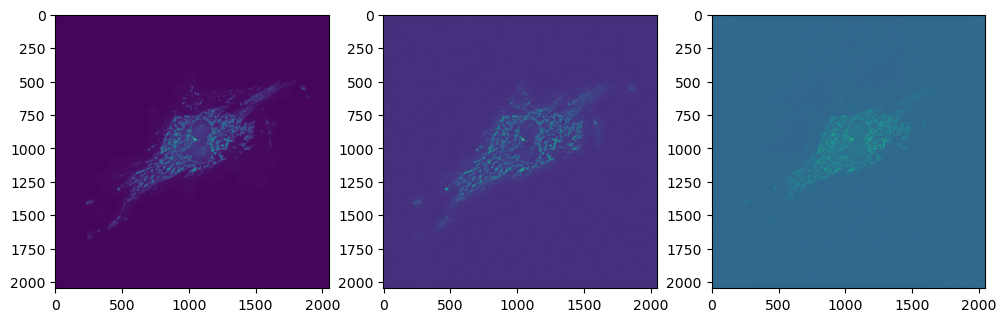

In [5]:
import matplotlib.pyplot as plt
_,ax = plt.subplots(figsize=(12,4),ncols=3)
ax[0].imshow(gt[15])
ax[1].imshow(pred[15])
ax[2].imshow(gt_lowsnr[15])

In [35]:
import numpy as np
idx  = np.random.randint(0,len(gt))
gt_tmp = gt[idx] - gt[idx].min()
gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min()
pred_tmp = pred[idx] - pred[idx].min()
# print(range_invariant_structural_similarity(gt_tmp, pred_tmp, ri_factor=None, data_range=gt_tmp.max() - gt_tmp.min()))
# print(range_invariant_structural_similarity(gt_tmp, pred_tmp, ri_factor= 1.0, data_range=gt_tmp.max() - gt_tmp.min()))
# print('Between GT and low SNR GT')
# print(range_invariant_structural_similarity(gt_tmp, gt_tmp_lowsnr, ri_factor=None, data_range=gt_tmp.max() - gt_tmp.min()))
# print(range_invariant_structural_similarity(gt_tmp, gt_tmp_lowsnr, ri_factor=1.0, data_range=gt_tmp.max() - gt_tmp.min()))

## Inspecting individual elements: luminance, contrast and structure

In [36]:
dicts = {}
for remove_min in [True, False]:
    gt_tmp = gt[idx] - gt[idx].min() * remove_min
    gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min() * remove_min
    pred_tmp = pred[idx] - pred[idx].min() * remove_min
    ssim_comp_dict = range_invariant_structural_similarity(gt_tmp, pred_tmp, ri_factor=None, data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
    dicts[remove_min] = ssim_comp_dict
    assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-10

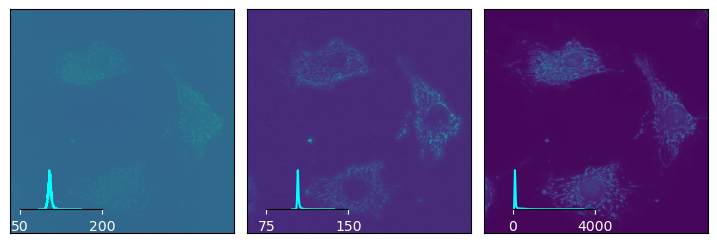

In [37]:
from disentangle.analysis.plot_utils import add_pixel_kde, clean_ax
import os

save_to_file = False
_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])
color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 1 if save_to_file else 4

add_pixel_kde(ax[0],
                  inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[1],
                  inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.06, hspace=0.06)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [38]:

def add_text(ax, text, img_shape, place='TOP_LEFT', facecolor='white', edgecolor='black'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(img_shape[1] * 20 / 500, img_shape[0] * 35 / 500, text, bbox=dict(facecolor=facecolor, edgecolor=edgecolor, alpha=0.9))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 500, s1 - s1 * 35 / 500, text, bbox=dict(facecolor=facecolor,edgecolor=edgecolor, alpha=0.9))


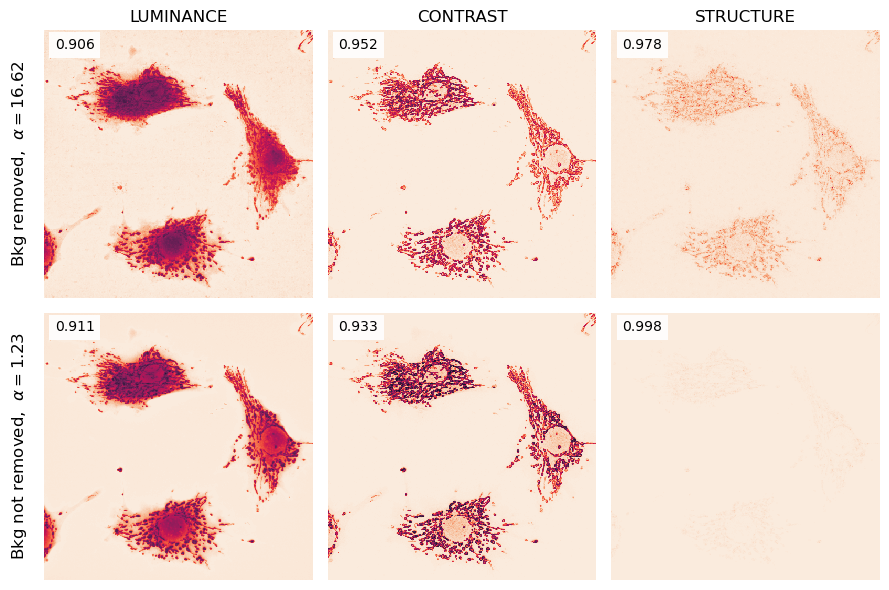

In [39]:
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import os
shape = list(dicts[True]['luminance'].shape)
fac = 1 if save_to_file else 4
_,ax = plt.subplots(figsize=(9,6),ncols=3,nrows=2)
# For True
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts[True][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
    val = f"{dicts[True][key][::fac,::fac].mean():.3f}"
    add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# For False
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts[False][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
    val = f"{dicts[False][key][::fac,::fac].mean():.3f}"
    add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')


clean_ax(ax)
ax[0,0].set_title('Luminance'.upper())
ax[0,1].set_title('Contrast'.upper())
ax[0,2].set_title('Structure'.upper())

alpha_true = round(dicts[True]['alpha'],2)
ax[0,0].set_ylabel('Bkg removed,  ' + f'$\\alpha=${alpha_true}', fontsize=12)

alpha_false = round(dicts[False]['alpha'],2)
ax[1,0].set_ylabel('Bkg not removed,  ' + f'$\\alpha=${alpha_false}', fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


In [32]:
gt_tmp.min()

52

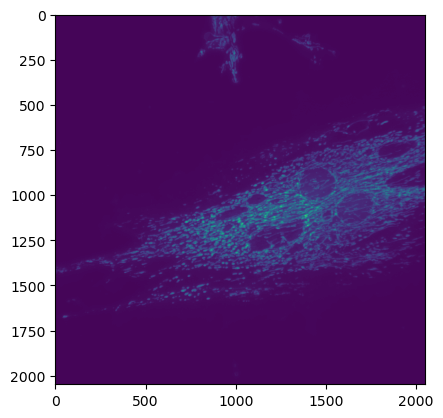

In [29]:
plt.imshow(gt_tmp)

# Manual varying of alpha: inspecting its uniqueness

In [ ]:
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict
save_to_file = True

ssim_components = defaultdict(list)
idx_list = []
alpha_list = np.concatenate([np.arange(0,300,1)])

for idx in np.random.choice(len(gt), size=30, replace=False):
    idx_list.append(idx)
    gt_cur = gt[idx] - gt[idx].min()
    pred_cur = pred[idx] - pred[idx].min()
    random_pred = np.random.rand(*gt_cur.shape)
    random_pred = random_pred - random_pred.min()


    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_cur,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    # luminance_arr = []
    # contrast_arr = []
    # structure_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
        # luminance_arr.append(ssim_dict['luminance'].mean())
        # contrast_arr.append(ssim_dict['contrast'].mean())
        # structure_arr.append(ssim_dict['structure'].mean())
    
    ssim_components['ssim'].append(ssim_arr)
    # ssim_components['luminance'].append(luminance_arr)
    # ssim_components['contrast'].append(contrast_arr)
    # ssim_components['structure'].append(structure_arr)
    

100%|██████████| 300/300 [00:24<00:00, 12.35it/s]


/group/jug/ashesh/ri_ssim/images/ssim_uniqueness_Idx94_N2V-2402-31.png


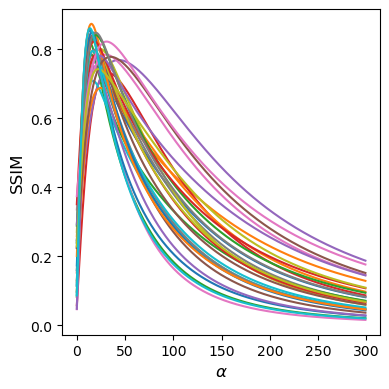

In [ ]:
import pandas as pd
_,ax = plt.subplots(figsize=(4,4))
pd.DataFrame(np.stack(ssim_components['ssim']).T, index=alpha_list).plot(legend=False, ax=ax)
ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('SSIM', fontsize=12)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_uniqueness_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


# Manual varying of alpha: inspecting the components

In [ ]:
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict

gt_cur = gt[idx] - gt[idx].min()
pred_cur = pred[idx] - pred[idx].min()
random_pred = np.random.rand(*gt_cur.shape)
random_pred = random_pred - random_pred.min()

pred_list = [pred_cur, pred_cur[::-1], pred_cur[:,::-1], pred_cur[::-1,::-1], random_pred]
alpha_list = np.concatenate([np.arange(0,20,0.03),np.arange(20,100,0.1), np.arange(100,300,1), np.arange(300,1000,3)])
ssim_components = defaultdict(list)

for pred_tmp in pred_list:
    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_tmp,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    luminance_arr = []
    contrast_arr = []
    structure_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
        luminance_arr.append(ssim_dict['luminance'].mean())
        contrast_arr.append(ssim_dict['contrast'].mean())
        structure_arr.append(ssim_dict['structure'].mean())
    
    ssim_components['ssim'].append(ssim_arr)
    ssim_components['luminance'].append(luminance_arr)
    ssim_components['contrast'].append(contrast_arr)
    ssim_components['structure'].append(structure_arr)
    

100%|██████████| 1901/1901 [02:42<00:00, 11.68it/s]


/group/jug/ashesh/ri_ssim/images/ssim_components_Idx26_N2V-2402-31.png


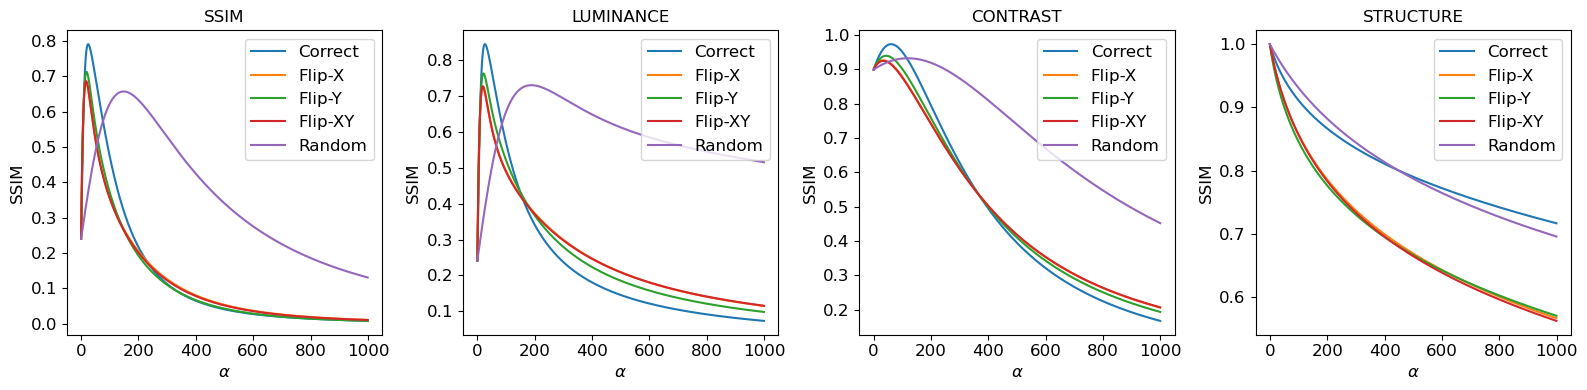

In [ ]:
import pandas as pd
import os
save_to_file = False

_,ax = plt.subplots(figsize=(16,4),ncols=4)
for i, key in enumerate(['ssim','luminance','contrast','structure']):
    df = pd.DataFrame(np.stack(ssim_components[key]).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
    df.plot(fontsize=12, ax=ax[i]).legend(loc='upper right', fontsize=12)
    ax[i].set_title(key.upper(), fontsize=12)

for i in range(4):
    ax[i].set_xlabel('$\\alpha$', fontsize=12)
    ax[i].set_ylabel('SSIM', fontsize=12)

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_components_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [ ]:
np.argmax(ssim_components['SSIM'][0])

IndexError: list index out of range

In [ ]:
idx = np.argmax(ssim_components['contrast'][0])
alpha_list[idx]

78

In [ ]:
dicts[False]['alpha']

1.872448264383117

'N2V-2402-31.png'